In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import time
import itertools as it
import gensim
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Word2Vec
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from collections import defaultdict
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [ ]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
data.shape

(1050, 15)

In [ ]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
data.uniq_id.duplicated().sum()

0

In [ ]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [ ]:
#df['product_category_tree']
#df['product_rating'].unique()
#df['overall_rating'].unique()
#df['brand'].unique()
data['product_specifications'].unique()

array(['{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}',
       '{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {

In [ ]:
data['product_category_tree'].nunique()

642

In [ ]:
data['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

# **I. Définition et numérisation des catégories**


In [ ]:
data_cat=data.copy()
def get_product_category(category_tree):
    if 'Watches' in category_tree:
        return 'Watches'
    elif 'Home Furnishing' in category_tree:
        return 'Home Furnishing'
    elif 'Baby Care' in category_tree:
        return 'Baby Care'
    elif 'Home Decor & Festive Needs' in category_tree:
        return 'Home Decor & Festive Needs'
    elif 'Kitchen & Dining' in category_tree:
        return 'Kitchen & Dining'
    elif 'Beauty and Personal Care' in category_tree:
        return 'Beauty and Personal Care'
    elif 'Computers' in category_tree:
        return 'Computers'
    else:
        return 'Other'

data_cat['product_category'] = data_cat['product_category_tree'].apply(get_product_category)

In [ ]:
data_cat.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care


In [ ]:
data_cat['product_category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
data_cat_num=data.copy()
label_encoder = LabelEncoder()
data_cat_num['label'] = label_encoder.fit_transform(data_cat['product_category'])

In [ ]:
data_cat_num['product_category']=data_cat['product_category']
data_cat_num.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,label,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",0,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",0,Baby Care


In [ ]:
data_cat_num.to_csv('/content/drive/My Drive/Flipkart/data_cat_num.csv', index=False)

# **II. Pré-traitement du corpus**




Nous allons nous intéresser dans cette partie à la colonne 'description' qui constitue notre corpus.

In [ ]:
df=data_cat_num[['description']]

On commence par transformer le texte en miniscule, la suppression de la ponctuation et des chiffres puis on applique une tokenization à l'ensemble de la colonne 'description'.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# Télécharger les ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Nettoyage**

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)   # Supprime les URLs
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Supprime les caractères spéciaux
    text = ''.join([c for c in text if c not in punctuation])  # Supprime la ponctuation
    text = text.lower()

    return text

In [ ]:
text_example = "Les données de ce projet sont sur le site https://openclassrooms.com/fr/paths/164/projects. Attention ! il faut prétraiter le texte, le tokeniser et le nettoyer des caractères spéciaux ?%@&."
texte_nettoye = clean_text(text_example)
print(texte_nettoye)

les donn es de ce projet sont sur le site  attention   il faut pr traiter le texte  le tokeniser et le nettoyer des caract res sp ciaux      


In [ ]:
df_1 = df.copy()
df_1['description'] = df_1['description'].astype(str).str.lower()

In [ ]:
# Appliquer la fonction clean_text à la colonne 'description' du DataFrame 'df'
df_1['description_cleaned'] = df_1['description'].apply(clean_text)

**Tokenisation**

In [ ]:
# Tokenisation du texte
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

text_example_2 = "les donn es de ce projet sont sur le site  attention   il faut pr traiter le texte et le nettoyer des caract res sp ciaux"
tokens= tokenize_text(text_example_2)
print(tokens)

['les', 'donn', 'es', 'de', 'ce', 'projet', 'sont', 'sur', 'le', 'site', 'attention', 'il', 'faut', 'pr', 'traiter', 'le', 'texte', 'et', 'le', 'nettoyer', 'des', 'caract', 'res', 'sp', 'ciaux']


In [ ]:
df_1['description_tokenize'] = df_1['description_cleaned'].apply(tokenize_text)
df_1['description_tokenize']

0       [key, features, of, elegance, polyester, multi...
1       [specifications, of, sathiyas, cotton, bath, t...
2       [key, features, of, eurospa, cotton, terry, fa...
3       [key, features, of, santosh, royal, fashion, c...
4       [key, features, of, jaipur, print, cotton, flo...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, for, rs...
Name: description_tokenize, Length: 1050, dtype: object

**Suppression des stopwords**

In [ ]:
# Suppression des stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))  # Utilisez la langue appropriée pour votre texte
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

df_1['description_without_stopwords'] = df_1['description_tokenize'].apply(remove_stopwords)
df_1.sample(3)

,description,description_cleaned,description_tokenize,description_without_stopwords
461,key features of vatika advance standard idli m...,key features of vatika advance standard idli m...,"[key, features, of, vatika, advance, standard,...","[key, features, vatika, advance, standard, idl..."
864,buy rce hp probook 4430s 6 cell laptop battery...,buy rce hp probook 4430s 6 cell laptop battery...,"[buy, rce, hp, probook, 4430s, 6, cell, laptop...","[buy, rce, hp, probook, 4430s, 6, cell, laptop..."
44,key features of akup i-loves-music ceramic mug...,key features of akup i loves music ceramic mug...,"[key, features, of, akup, i, loves, music, cer...","[key, features, akup, loves, music, ceramic, m..."


**Lemmatisation**

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(str(text))

    cleaned_tokens = []  # Initialise la liste des tokens lemmatisés

    # Remplacement des caractères spéciaux
    tokens = [token.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('_', ' ') for token in tokens]

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token) > 2 and token not in stop_words]
    cleaned_tokens += [[lemmatizer.lemmatize(w).replace("'", "") for w in lemmatized_tokens]]

    return cleaned_tokens

# Appliquer la lemmatisation sur la colonne 'description_without_stopwords'
df_1['description_lemmatized'] = df_1['description_without_stopwords'].apply(lemmatize_text)

In [ ]:
df_1['description_lemmatized'].values[0]

[['key',
  'features',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  '213',
  'cm',
  'height',
  'pack',
  'price',
  'rs',
  '899',
  'curtain',
  'enhances',
  'look',
  'interiors',
  'curtain',
  'made',
  '100',
  'high',
  'quality',
  'polyester',
  'fabric',
  'features',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'makes',
  'room',
  'environment',
  'romantic',
  'loving',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'apparance',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'designs',
  'surreal',
  'attention',
  'sure',
  'steal',
  'hearts',
  'contemporary',
  'eyelet',
  'valance',
  'curtains',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',
  'morning',
  'welcome',
  'bright',
  'sun',
  'rays',
  'want',
  'wish',
  'g

**Mettre tous les mots de la colonne df_1['description_lemmatized'] dans une liste**

In [ ]:
text_total = []
for i in range(len(df_1['description_lemmatized'])) :
  text_total += df_1['description_lemmatized'].values[i]
text_total

[['key',
  'features',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  '213',
  'cm',
  'height',
  'pack',
  'price',
  'rs',
  '899',
  'curtain',
  'enhances',
  'look',
  'interiors',
  'curtain',
  'made',
  '100',
  'high',
  'quality',
  'polyester',
  'fabric',
  'features',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'makes',
  'room',
  'environment',
  'romantic',
  'loving',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'apparance',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'designs',
  'surreal',
  'attention',
  'sure',
  'steal',
  'hearts',
  'contemporary',
  'eyelet',
  'valance',
  'curtains',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',
  'morning',
  'welcome',
  'bright',
  'sun',
  'rays',
  'want',
  'wish',
  'g

In [ ]:
if isinstance(text_total, list):
    print("text_total is a list")
else:
    print("text_total is not a list")

text_total is a list


In [ ]:
if all(isinstance(item, list) for item in text_total):
    print("All elements of text_total are lists")
else:
    print("Not all elements of text_total are lists")

All elements of text_total are lists


In [ ]:
if all(all(isinstance(word, str) for word in sublist) for sublist in text_total):
    print("All elements of the sublists in text_total are words")
else:
    print("Not all elements of the sublists in text_total are words")


All elements of the sublists in text_total are words


Le nombre des mots et de mot unique de la colonne df_1['description_lemmatized']


In [ ]:
from collections import Counter

# Aplatir la liste de listes text_total
flattened_text = [word for sublist in text_total for word in sublist]

word_counter = Counter(flattened_text)
num_unique_words = len(word_counter)

print('Le nombre de mots de la colonne description_lemmatized         ==>', len(flattened_text))
print('Le nombre de mots uniques de la colonne description_lemmatized ==>', num_unique_words)

Le nombre de mots de la colonne description_lemmatized         ==> 59392
Le nombre de mots uniques de la colonne description_lemmatized ==> 5937


# **II. Bags Of Words**

# **II.1 Création des modèles bigrammes et trigrammes**

In [ ]:
# Convertir la liste de listes en une liste de phrases
phrases = [' '.join(tokens) for tokens in text_total]

tokenized_phrases = [phrase.split() for phrase in phrases]

bigram_model = Phrases(tokenized_phrases, min_count=2, threshold=10)
trigram_model = Phrases(bigram_model[tokenized_phrases], min_count=2, threshold=10)

# Appliquer les modèles de bigrammes et trigrammes aux phrases
tokenized_phrases_with_bigrams = [bigram_model[phrase] for phrase in tokenized_phrases]
tokenized_phrases_with_trigrams = [trigram_model[bigram_phrase] for bigram_phrase in tokenized_phrases_with_bigrams]

# Afficher un exemple de phrase avec les bigrammes et trigrammes
print(tokenized_phrases_with_trigrams[0])

['key_features', 'elegance_polyester_multicolor', 'abstract_eyelet_door_curtain', 'floral', 'curtain', 'elegance_polyester_multicolor', 'abstract_eyelet_door_curtain', '213_cm_height', 'pack_price_rs', '899', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made_100', 'high_quality', 'polyester', 'fabric', 'features', 'eyelet_style', 'stitch', 'metal_ring', 'makes', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle_anti_shrinkage', 'elegant', 'apparance', 'give_home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'beauty', 'given', 'soothing', 'prints', 'bring_home', 'elegant', 'curtain', 'softly', 'filters', 'light', 'room', 'get', 'rig

In [ ]:
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]

In [ ]:
# Form Bigrams
df_1['bigram'] = make_bigrams(df_1['description_lemmatized'])
df_1['bigram_trigram'] = make_trigrams(df_1['bigram'])
df_1.sample(3)

,description,description_cleaned,description_tokenize,description_without_stopwords,description_lemmatized,bigram,bigram_trigram
750,buy rajasthan crafts abstract single quilts & ...,buy rajasthan crafts abstract single quilts ...,"[buy, rajasthan, crafts, abstract, single, qui...","[buy, rajasthan, crafts, abstract, single, qui...","[[buy, rajasthan, crafts, abstract, single, qu...","([buy, rajasthan_crafts, abstract_single, quil...","([buy_rajasthan_crafts, abstract_single_quilts..."
11,"cartier w6701005 analog watch - for boys, men...",cartier w6701005 analog watch for boys men...,"[cartier, w6701005, analog, watch, for, boys, ...","[cartier, w6701005, analog, watch, boys, men, ...","[[cartier, w6701005, analog, watch, boys, men,...","([cartier, w6701005, analog_watch, boys_men, b...","([cartier, w6701005, analog_watch_boys_men, bu..."
41,key features of kripa's printed cushions cover...,key features of kripa s printed cushions cover...,"[key, features, of, kripa, s, printed, cushion...","[key, features, kripa, printed, cushions, cove...","[[key, features, kripa, printed, cushions, cov...","([key_features, kripa, printed_cushions, cover...","([key_features, kripa, printed_cushions, cover..."


**II.2  Bags of words sans les bigrammes**


In [ ]:
# Convertir la liste de phrases en une seule chaîne de caractères
text_str = [' '.join(tokens) for tokens in tokenized_phrases]

# Création de l'objet CountVectorizer sans les bigrammes
vectorizer = CountVectorizer(strip_accents='unicode')

# Appliquer le CountVectorizer sur la chaîne de caractères combinée
X_vect = vectorizer.fit_transform(text_str)

# Créer un DataFrame avec les résultats du CountVectorizer
df_vectorized = pd.DataFrame(X_vect.toarray(), columns=vectorizer.get_feature_names_out())
df_vectorized.shape

(1050, 5937)

# **II.3 Bag of words avec les bigrammes**

**1. CountVectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convertir la liste de phrases avec bigrammes en une seule chaîne de caractères
text_combined_with_bigrams = [' '.join(tokens) for tokens in tokenized_phrases_with_bigrams]

# Création de l'objet CountVectorizer avec les bigrammes
vectorizer_bigram = CountVectorizer(strip_accents='unicode')

# Appliquer le CountVectorizer sur la chaîne de caractères combinée avec les bigrammes
X_vect_bigram = vectorizer_bigram.fit_transform(text_combined_with_bigrams)

# Créer un DataFrame avec les résultats du CountVectorizer avec les bigrammes
df_vectorized_bigram = pd.DataFrame(X_vect_bigram.toarray(), columns=vectorizer_bigram.get_feature_names_out())
df_vectorized_bigram.shape

(1050, 7605)

In [ ]:
df_vectorized_bigram.sample(5)

,00,000,001,0021,004,005,0083,01,011,01433cmgy,...,zero,zikrak,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom
407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
if df_vectorized_bigram['0021'].notnull().any():
    print("Il y a des valeurs non nulles dans la colonne 'zipper'")
else:
    print("La colonne 'zipper' ne contient que des valeurs nulles")

Il y a des valeurs non nulles dans la colonne 'zipper'


In [ ]:
all_zeros = True

for column in df_vectorized_bigram.columns:
    if (df_vectorized_bigram[column] != 0).any():
        all_zeros = False
        print(f"La colonne '{column}' ne contient pas que des zéros")

if all_zeros:
    print("Toutes les colonnes contiennent uniquement des zéros")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
La colonne 'disk' ne contient pas que des zéros
La colonne 'disks' ne contient pas que des zéros
La colonne 'disney' ne contient pas que des zéros
La colonne 'disorders' ne contient pas que des zéros
La colonne 'display' ne contient pas que des zéros
La colonne 'displayed' ne contient pas que des zéros
La colonne 'displayed_screen' ne contient pas que des zéros
La colonne 'disposable' ne contient pas que des zéros
La colonne 'distance' ne contient pas que des zéros
La colonne 'distinct' ne contient pas que des zéros
La colonne 'distinctive' ne contient pas que des zéros
La colonne 'distinctive_coffee' ne contient pas que des zéros
La colonne 'distinguishes' ne contient pas que des zéros
La colonne 'distractions' ne contient pas que des zéros
La colonne 'distribute' ne contient pas que des zéros
La colonne 'distribution' ne contient pas que des zéros
La colonne 'dive' ne contient pas que des zéros
La colonne '

In [ ]:
print(X_vect_bigram)
#print(X_bigram.toarray())


  (0, 4038)	1
  (0, 2802)	3
  (0, 4739)	3
  (0, 890)	3
  (0, 2644)	4
  (0, 3149)	1
  (0, 2346)	5
  (0, 282)	3
  (0, 3623)	2
  (0, 5086)	2
  (0, 5508)	1
  (0, 813)	1
  (0, 2843)	1
  (0, 4310)	1
  (0, 3912)	1
  (0, 4395)	1
  (0, 3651)	1
  (0, 5403)	2
  (0, 2983)	1
  (0, 3041)	1
  (0, 2975)	2
  (0, 6698)	1
  (0, 6634)	1
  (0, 4572)	1
  (0, 4429)	1
  :	:
  (1048, 3218)	1
  (1048, 1800)	1
  (1048, 1412)	1
  (1048, 5979)	1
  (1048, 6625)	1
  (1048, 131)	1
  (1048, 4541)	1
  (1048, 6627)	1
  (1048, 4994)	1
  (1048, 7270)	1
  (1048, 7325)	1
  (1049, 1674)	1
  (1049, 5561)	1
  (1049, 2411)	1
  (1049, 6232)	1
  (1049, 628)	1
  (1049, 5979)	1
  (1049, 4984)	1
  (1049, 6625)	1
  (1049, 5511)	1
  (1049, 2464)	1
  (1049, 3512)	1
  (1049, 6626)	1
  (1049, 4152)	2
  (1049, 7111)	2


**2. TF-IDF Vectorizer**

In [ ]:
# Création de l'objet TfidfVectorizer sans les bigrammes
tfidf_vect = TfidfVectorizer(strip_accents='unicode')

# Appliquer le TfidfVectorizer sur la chaîne de caractères combinée
X_tfidf_bigram = tfidf_vect.fit_transform(text_combined_with_bigrams)
# Créer un DataFrame avec les résultats du TfidfVectorizer
df_tfidf_bigram= pd.DataFrame(X_tfidf_bigram.toarray(), columns=tfidf_vect.get_feature_names_out())
df_tfidf_bigram.shape

(1050, 7605)

In [ ]:
print(X_tfidf_bigram)

  (0, 4489)	0.06135994351061683
  (0, 1502)	0.05582032997146826
  (0, 6058)	0.039672279070854466
  (0, 5092)	0.04441287015209008
  (0, 2177)	0.04114036154217747
  (0, 1553)	0.043271593201364825
  (0, 2577)	0.05582032997146826
  (0, 2037)	0.051113902521810466
  (0, 2723)	0.08698583353033634
  (0, 4648)	0.05141706668281278
  (0, 6171)	0.04266516768539795
  (0, 886)	0.06553068794492314
  (0, 4650)	0.041010907905731746
  (0, 7099)	0.06657259216977096
  (0, 2495)	0.07601385241983909
  (0, 2801)	0.07198481786127309
  (0, 3334)	0.039672279070854466
  (0, 6539)	0.02764305184392265
  (0, 6751)	0.0821306545436089
  (0, 1055)	0.07868585023099348
  (0, 5897)	0.06897549225753859
  (0, 3353)	0.062085883632307715
  (0, 4228)	0.04997262557108521
  (0, 3084)	0.08698583353033634
  (0, 6470)	0.08698583353033634
  :	:
  (1048, 4541)	0.35829848152028665
  (1048, 131)	0.35829848152028665
  (1048, 6625)	0.28999088721065175
  (1048, 5979)	0.13643254538285962
  (1048, 1412)	0.1719450422532647
  (1048, 1800)	0.

In [ ]:
df_tfidf_bigram.sample(5)

,00,000,001,0021,004,005,0083,01,011,01433cmgy,...,zero,zikrak,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom
365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bigram_counter = Counter()
for phrase in tokenized_phrases_with_bigrams:
    bigram_counter.update(phrase)

In [ ]:
most_common_bigrams = bigram_counter.most_common()

In [ ]:
for bigram, frequency in most_common_bigrams[:20]:
    print(bigram, frequency)

free_shipping 419
cash_delivery 419
genuine_products 414
flipkart_com 370
buy 344
30_day 324
replacement_guarantee 324
specifications 312
price_rs 299
rs 233
key_features 207
type 206
pack 198
online_rs 195
cm 188
color 185
analog_watch 185
cotton 179
set 157
day_replacement 146


**Réduction dimentionnelle et visualisation**

In [ ]:
pca_600 = PCA(n_components=600)
X_tfidf_pca = pca_600.fit_transform(df_tfidf_bigram)

print(X_tfidf_pca.shape)

(1050, 600)


In [ ]:
proportion = np.sum(pca_600.explained_variance_ratio_)
print('Proportion expliquée par les deux premières composantes principales : {}'.format(proportion))

Proportion expliquée par les deux premières composantes principales : 0.8294919706202362


In [ ]:
T_1 = time.time()

X_embedded_pca = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(X_tfidf_pca)

df_tsne_pca = pd.DataFrame(X_embedded_pca[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne_pca["class"] = data_cat_num['product_category']

In [ ]:
df_tsne_pca.shape

(1050, 3)

In [ ]:
from sklearn.cluster import KMeans

kmeans_pca = KMeans(n_clusters=7, n_init=100, random_state=42)
kmeans_pca.fit(X_embedded_pca)
df_tsne_pca['tf-idf_cluster_cv'] = kmeans_pca.labels_
T_2 = np.round(time.time() - T_1, 0)
ARI = np.round(metrics.adjusted_rand_score(data_cat_num['product_category'], kmeans_pca.labels_), 4)

print("ARI: {}, Time: {} seconds".format(ARI, T_2))


ARI: 0.2058, Time: 125.0 seconds


In [ ]:
df_tsne_pca.sample(5)

,tsne1,tsne2,class,tf-idf_cluster_cv
297,-2.364754,62.831379,Baby Care,2
723,2.787185,6.375790,Home Furnishing,0
601,-4.556850,-46.352600,Kitchen & Dining,4
796,-35.862946,-2.288933,Watches,3
479,26.487858,42.260616,Computers,2


Text(0.5, 1.0, 'TfidfVectorizer, catégories du Kmeans avec PCA')

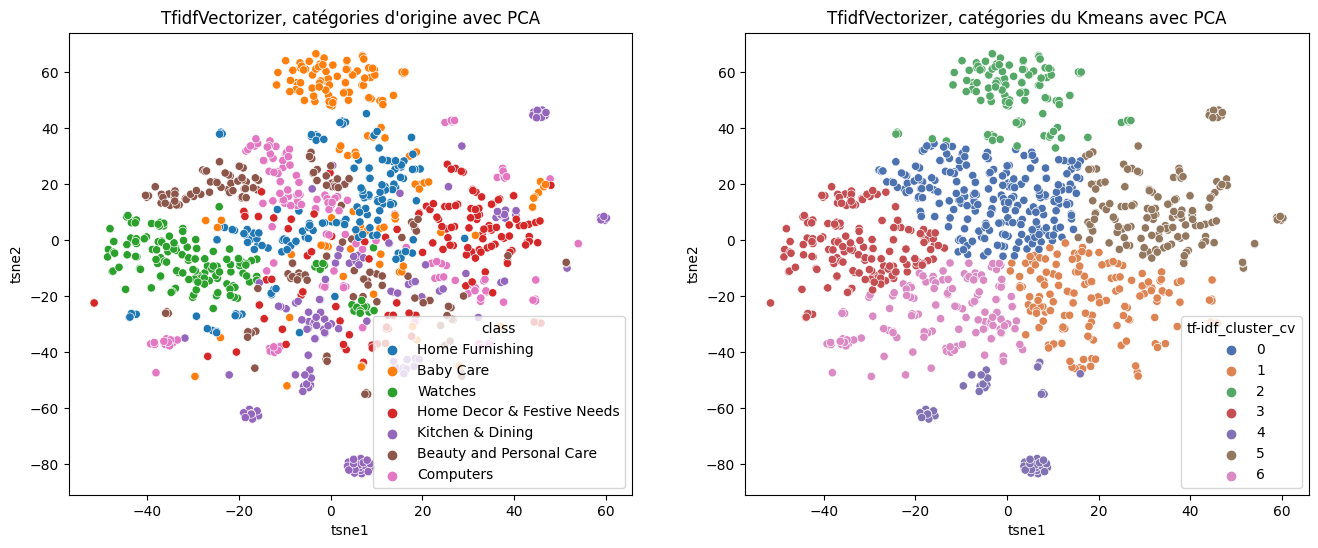

In [ ]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne_pca, x="tsne1", y="tsne2", hue="class")
plt.title("TfidfVectorizer, catégories d'origine avec PCA")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne_pca, x="tsne1", y="tsne2", hue="tf-idf_cluster_cv", palette="deep" )
plt.savefig('/content/drive/My Drive/Flipkart/TFidf-plot.png')

plt.title("TfidfVectorizer, catégories du Kmeans avec PCA")

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# import tensorflow_hub as hub


In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = text_total
sentences = [gensim.utils.simple_preprocess(str(text)) for text in text_total]

# **Word2Vec sans les bigrammes**

In [ ]:
# Entraîner le modèle Word2Vec sur text_total

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
word_vectors = w2v_model.wv
w2v_words = word_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5077
Word2Vec trained


In [ ]:
#w2v_model.wv.index_to_key
w2v_words

['rs',
 'products',
 'free',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'cm',
 'day',
 'flipkart',
 'com',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price',
 'watch',
 'color',
 'mug',
 'baby',
 'pack',
 'material',
 'set',
 'type',
 'cotton',
 'box',
 'general',
 'package',
 'analog',
 'sales',
 'number',
 'warranty',
 'quality',
 'details',
 'product',
 'brand',
 'best',
 'model',
 'design',
 'ceramic',
 'key',
 'laptop',
 'fabric',
 'prices',
 'showpiece',
 'made',
 'great',
 'perfect',
 'inch',
 'india',
 'men',
 'size',
 'usb',
 'dimensions',
 'ideal',
 'girl',
 'home',
 'skin',
 'coffee',
 'multicolor',
 'contents',
 'combo',
 'water',
 'gift',
 'women',
 'printed',
 'discounts',
 'ml',
 'black',
 'width',
 'mugs',
 'wash',
 'also',
 'print',
 'care',
 'blue',
 'battery',
 'cover',
 'power',
 'light',
 'use',
 'adapter',
 'yes',
 'pattern',
 'height',
 'high',
 'style',
 'length',
 'easy',
 'one',
 'dress',
 'name',
 'weight',
 'round

In [ ]:
# Exemple : Calcul de similarité entre deux mots
similarity1 = word_vectors.similarity("home", "decorate")
similarity2= word_vectors.similarity("baby", "protect")
print("Similarité entre 'home' et 'decorate':", similarity1)
print("Similarité entre 'baby' et 'protect':", similarity2)

Similarité entre 'home' et 'decorate': 0.5422573
Similarité entre 'baby' et 'protect': -0.068360426


In [ ]:
# Exemple : Trouver les mots les plus similaires à un mot donné
baby_similar_words = word_vectors.most_similar("baby")
care_similar_words = word_vectors.most_similar("care")
print("Mots similaires à 'baby':", baby_similar_words)
print("Mots similaires à 'care':", care_similar_words)

Mots similaires à 'baby': [('plan', 0.6045438647270203), ('striped', 0.587702214717865), ('romper', 0.5761868953704834), ('sleepsuit', 0.5568453669548035), ('girl', 0.5552898049354553), ('legging', 0.5437501668930054), ('heavenly', 0.5339425802230835), ('cotton', 0.5332435965538025), ('waist', 0.5276079773902893), ('got', 0.5273153781890869)]
Mots similaires à 'care': [('bearberry', 0.5872699022293091), ('softener', 0.577704131603241), ('celsius', 0.568610668182373), ('result', 0.5335891246795654), ('degree', 0.5256459712982178), ('machine', 0.5119656920433044), ('bleach', 0.5107560157775879), ('brocade', 0.5009298324584961), ('wash', 0.47732454538345337), ('pitambari', 0.4760456085205078)]


In [ ]:
# Obtenir la représentation vectorielle d'un mot
word_vector = w2v_model.wv.get_vector("care")
print("Représentation vectorielle de 'care':", word_vector)

Représentation vectorielle de 'care': [ 0.57383937  0.2612663   2.3772254   1.1183486  -1.2399305   1.1120594
 -0.4226277  -0.39535025  2.677173   -0.7883405   2.1826882  -0.8262167
 -0.3220862  -0.6641882   0.18878132 -0.32059622 -0.94337624  0.19863275
 -0.70323896  0.7326765  -1.745166   -0.18524976 -2.769821   -0.45492798
 -1.2101686   1.6110058   0.8043437   0.8390701  -0.10958149  1.1082855
 -1.9253356  -0.6830376  -0.5079215   0.20715377  0.88095945 -1.2630297
  0.7018049   1.6012183   1.697127    0.57009673  0.76644826  2.193619
  1.0533124  -1.7482262  -0.03317497  0.92014635  0.1537813   0.3149981
 -0.10269433 -0.6944341  -0.0582898   0.58056253 -1.3309333   2.159207
  0.6186994  -1.1339675  -1.5013059  -2.487219    1.7814093   1.5480117
  0.13760778 -0.5013201  -0.32205707 -2.115125    0.88572425 -0.5110515
 -0.16446795 -0.4764888  -0.46702257  1.1048437   0.5725415   0.9414726
  0.75915366 -0.01648883 -0.46467927 -1.1931466  -0.16097152 -1.4869349
  2.4924402   1.3385588   

In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

tokenized_sentences = tokenizer.texts_to_sequences(sentences)
x_sentences = pad_sequences(tokenized_sentences, maxlen=maxlen, padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5078


In [ ]:
# Liste des vecteurs de phrases
sentence_vectors = []

# Parcours des phrases tokenisées
for sentence in tokenized_sentences:
    # Initialisation du vecteur de phrase
    sentence_vector = np.zeros_like(word_vectors[0])
    word_count = 0

    # Parcours des mots dans la phrase
    for word in sentence:
        # Vérification si le mot est présent dans les embeddings de mots
        if word in word_vectors:
            sentence_vector += word_vectors[word]
            word_count += 1

    # Calcul de la moyenne des vecteurs de mots
    if word_count > 0:
        sentence_vector /= word_count

    # Ajout du vecteur de phrase à la liste
    sentence_vectors.append(sentence_vector)


In [ ]:
# Créer un DataFrame à partir des vecteurs de phrases
df_sentence_vectors = pd.DataFrame(sentence_vectors)

# Afficher la forme du DataFrame
print("Shape of the DataFrame:", df_sentence_vectors.shape)


Shape of the DataFrame: (1050, 300)


In [ ]:
# Réduction de dimension avec PCA
pca_8= PCA(n_components=8)
pca_w2v_result = pca_8.fit_transform(df_sentence_vectors)

In [ ]:
proportion = np.sum(pca_8.explained_variance_ratio_)
print('Proportion expliquée par les deux premières composantes principales : {}'.format(proportion))

Proportion expliquée par les deux premières composantes principales : 0.8242186307907104


In [ ]:
T_1 = time.time()
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_w2v_result = tsne.fit_transform(pca_w2v_result)
df_w2v_tsne = pd.DataFrame(tsne_w2v_result, columns=['tsne1', 'tsne2'])
df_w2v_tsne["class"] = data_cat_num['product_category']

In [ ]:
# Appliquer K-means sur les données réduites
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(tsne_w2v_result)
# Ajouter les résultats au DataFrame
df_w2v_tsne['w2v_cluster'] = clusters
T_2 = np.round(time.time() - T_1, 0)
ARI = np.round(metrics.adjusted_rand_score(data_cat_num['product_category'], clusters), 4)

print("ARI: {}, Time: {} seconds".format(ARI, T_2))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI: 0.2933, Time: 23.0 seconds


In [ ]:
df_w2v_tsne.sample(3)

,tsne1,tsne2,class,w2v_cluster
278,-36.503986,0.248258,Watches,6
570,2.505500,39.857555,Watches,3
999,-20.399502,-1.899922,Home Furnishing,6


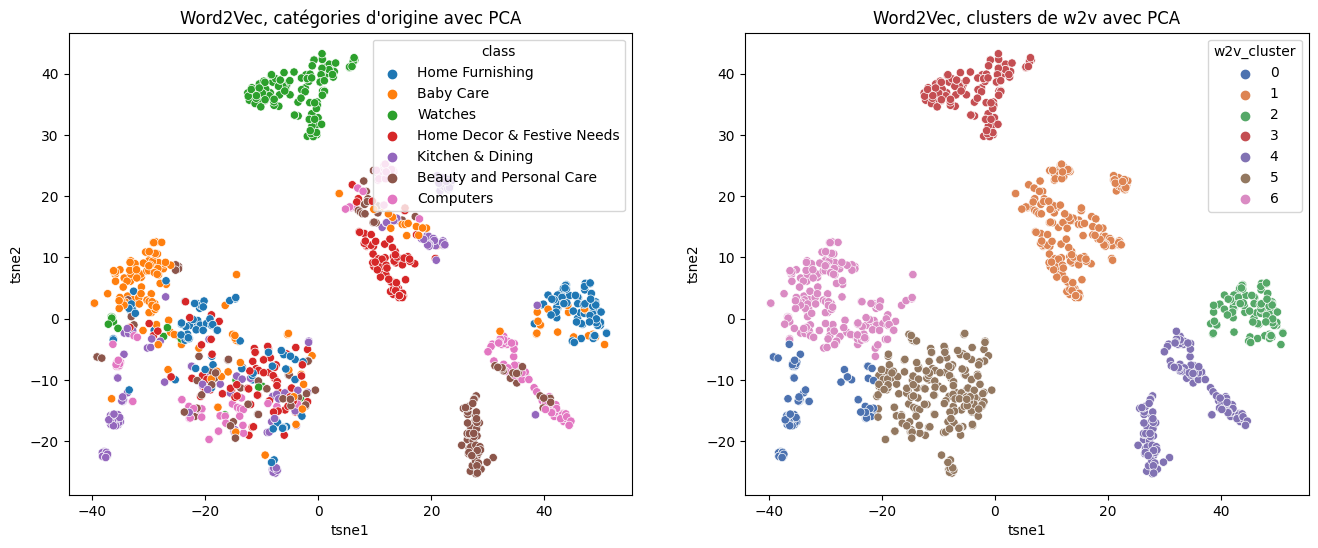

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une figure et des sous-graphiques
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Tracer le premier graphique pour les catégories d'origine avec PCA
sns.scatterplot(data=df_w2v_tsne, x="tsne1", y="tsne2", hue="class", ax=ax1)
ax1.set_title("Word2Vec, catégories d'origine avec PCA")

# Tracer le deuxième graphique pour les clusters de w2v avec PCA
sns.scatterplot(data=df_w2v_tsne, x="tsne1", y="tsne2", hue="w2v_cluster", palette="deep", ax=ax2)
ax2.set_title("Word2Vec, clusters de w2v avec PCA")
plt.savefig('/content/drive/My Drive/Flipkart/Word2Vec-plot.png')
# Afficher la figure
plt.show()


# **Word2Vec avec Bigrammes**

In [ ]:
sentences = tokenized_phrases_with_bigrams
# Création du modèle Word2Vec
Word2Vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Obtention des vecteurs de mots
word_vectors = Word2Vec_model.wv

# Liste de phrases combinées avec des bigrammes
sentences_combined_with_bigrams = [' '.join(bigram_model[phrase]) for phrase in sentences]

# Création de l'objet CountVectorizer
count_vect = CountVectorizer(strip_accents='unicode')

# Appliquer le CountVectorizer sur les phrases combinées avec des bigrammes
X_counts_bigram = count_vect.fit_transform(sentences_combined_with_bigrams)

# Créer un DataFrame avec les résultats du CountVectorizer
df_word2vec_bigram = pd.DataFrame(X_counts_bigram.toarray(), columns=count_vect.get_feature_names_out())

df_word2vec_bigram.shape


(1050, 7605)

In [ ]:
# Afficher le vocabulaire
vocabulary = Word2Vec_model.wv.index_to_key
print(vocabulary)


['free_shipping', 'cash_delivery', 'genuine_products', 'flipkart_com', 'buy', '30_day', 'replacement_guarantee', 'specifications', 'price_rs', 'rs', 'key_features', 'type', 'pack', 'online_rs', 'cm', 'analog_watch', 'color', 'cotton', 'set', 'day_replacement', 'shipping_cash', 'products_30', 'material', 'online', 'best_prices', 'box', 'general_brand', 'sales_package', 'combo_set', 'ceramic_mug', 'size', 'design', 'product', 'brand', 'package', 'mug', 'model_name', 'contents_sales', 'features', 'blue', 'delivery', 'black', 'guarantee_free', 'light', 'yes', 'baby_girl', 'great_discounts', 'made', 'box_number', 'printed', 'inch', 'india_flipkart', 'ideal_baby', 'use', 'package_pack', 'white', 'box_sales', 'model_number', 'guarantee', 'delivery_genuine', 'prices_free', 'beautiful', 'height', 'products', 'style_code', 'fabric_care', 'quality', 'material_ceramic', 'general_details', 'discounts_genuine', 'width', 'home', 'general', 'fabric', 'baby_boy', 'brass', 'coffee_mug', 'warranty', 'ide

In [ ]:
# Exemple d'utilisation du modèle entraîné
# Rechercher les mots similaires à un mot donné
similar_words = Word2Vec_model.wv.most_similar("replacement_guarantee")
print(similar_words)

[('cash_delivery', 0.9916605353355408), ('30_day', 0.9859182238578796), ('free_shipping', 0.9841044545173645), ('great_discounts', 0.9614210724830627), ('genuine_products', 0.9562408924102783), ('lowest_prices', 0.9259591102600098), ('best_prices', 0.8970873355865479), ('flipkart_com', 0.63604736328125), ('router_rs', 0.6145127415657043), ('1599', 0.5241169929504395)]


In [ ]:
# Exploration de relations analogiques
def find_analogy_word(model, word1, word2, word3):
    """
    Trouve le mot qui complète la relation analogique word1 - word2 + word3.
    Par exemple, si word1 est "roi", word2 est "homme" et word3 est "femme", le mot retourné sera "reine".
    """
    try:
        result = model.wv.most_similar(positive=[word1, word3], negative=[word2], topn=1)
        analogy_word = result[0][0]
        similarity = result[0][1]
        return analogy_word, similarity
    except KeyError:
        return None

# Exemple d'utilisation
word1 = "general_'brand"
word2 = "sales_'package"
word3 = "combo_'set"
results = find_analogy_word(Word2Vec_model, word1, word2, word3)
if results:
    analogy_word = results[0]
    similarity = results[1]
    print(f"La relation analogique '{word1} - {word2} + {word3}' est associée à '{analogy_word}' avec une similarité de {similarity:.2f}")
else:
    print("Aucun mot analogique trouvé pour la relation donnée.")


Aucun mot analogique trouvé pour la relation donnée.


**Visualistion**

In [ ]:
# Réduction de dimension avec PCA
pca_300 = PCA(n_components=300)
X_pca_w2v_big = pca_300.fit_transform(df_word2vec_bigram)


In [ ]:
proportion = np.sum(pca_300.explained_variance_ratio_)
print('Proportion expliquée par les deux premières composantes principales : {}'.format(proportion))

Proportion expliquée par les deux premières composantes principales : 0.8617146552004955


In [ ]:
T_1=time.time()
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', n_iter=2000, init='random', perplexity=30, random_state=42)
tsne_w2v_big_result = tsne.fit_transform(X_pca_w2v_big)
df_w2v_big_tsne = pd.DataFrame(tsne_w2v_big_result, columns=['tsne1', 'tsne2'])
df_w2v_big_tsne["class"] = data_cat_num['product_category']

In [ ]:
# Appliquer K-means sur les données réduites
kmeans = KMeans(n_clusters=7, random_state=42)
clusters_w2v_big = kmeans.fit_predict(tsne_w2v_big_result)
# Ajouter les résultats au DataFrame
df_w2v_big_tsne['w2v_big_cluster'] = clusters_w2v_big
T_2 = np.round(time.time() - T_1, 0)
ARI_w2v_big = np.round(metrics.adjusted_rand_score(data_cat_num['product_category'], clusters_w2v_big), 4)

print("ARI: {}, Time: {} seconds".format(ARI, T_2))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI: 0.2933, Time: 28.0 seconds


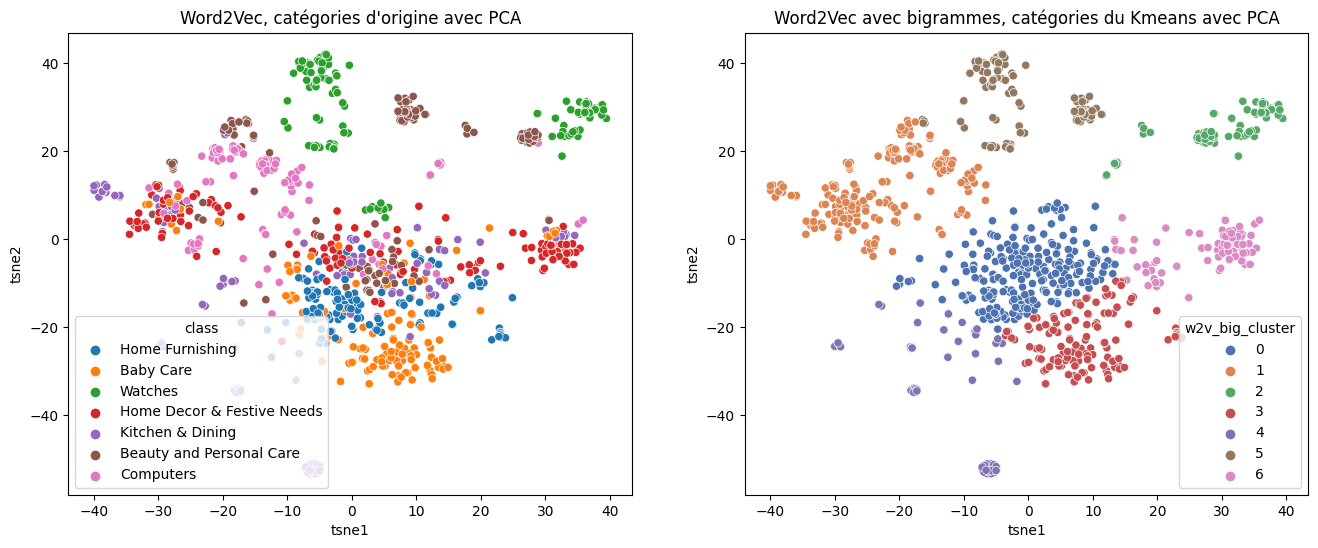

In [ ]:
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_w2v_big_tsne, x="tsne1", y="tsne2", hue="class")
plt.title("Word2Vec, catégories d'origine avec PCA")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_w2v_big_tsne, x="tsne1", y="tsne2", hue="w2v_big_cluster", palette="deep")
plt.title("Word2Vec avec bigrammes, catégories du Kmeans avec PCA")
plt.savefig('/content/drive/My Drive/Flipkart/Word2Vec-bigrammes-plot.png')
plt.show()


# **Transformers & Bert**

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
from transformers import TFAutoModel, AutoTokenizer

# Créer le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
model_name = "bert-base-uncased"
model = TFAutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
sentences = text_total
#sentences = [gensim.utils.simple_preprocess(str(text)) for text in text_total]
sentences = [gensim.utils.simple_preprocess(str(text)) for text in sentences]

max_length = 128  # Longueur maximale des séquences

In [ ]:
import torch

In [ ]:
# Fonction de préparation des sentences avec BERT
def bert_inp_fct(sentences, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoding['input_ids'][0])
        attention_masks.append(encoding['attention_mask'][0])

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    return input_ids, attention_masks

# Préparation des sentences avec BERT
features_bert, attention_masks = bert_inp_fct([' '.join(tokens) for tokens in sentences], tokenizer, max_length)

# Convertir les features en tenseurs PyTorch si nécessaire
#input_ids = torch.tensor(input_ids)
#attention_masks = torch.tensor(attention_masks)

In [ ]:
features_bert

tensor([[  101,  3145,  2838,  ..., 15480, 27745,   102],
        [  101, 15480,  2938,  ...,     0,     0,     0],
        [  101,  3145,  2838,  ...,  6609,  2640,   102],
        ...,
        [  101,  4965, 19169,  ...,     0,     0,     0],
        [  101,  4965,  2813,  ...,     0,     0,     0],
        [  101,  4965, 19169,  ...,     0,     0,     0]])

In [ ]:
time1 = time.time()

X_bert_embedded = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(features_bert)

df_bert_tsne = pd.DataFrame(X_bert_embedded[:,0:2], columns=['tsne1', 'tsne2'])
df_bert_tsne["class"] = data_cat_num['product_category']

bert_clusters = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
bert_clusters.fit(X_bert_embedded)
df_bert_tsne['bert_cluster'] = bert_clusters.labels_

ARI_bert = np.round(metrics.adjusted_rand_score(data_cat_num['product_category'], bert_clusters.labels_),4)
time2 = np.round(time.time() - time1,0)

print("BERT : ")
print("-----------------")
print("ARI : ", ARI_bert, "time : ", time2)
print("-----------------")

BERT : 
-----------------
ARI :  0.0854 time :  27.0
-----------------


Text(0.5, 1.0, 'BERT, catégories du Kmeans')

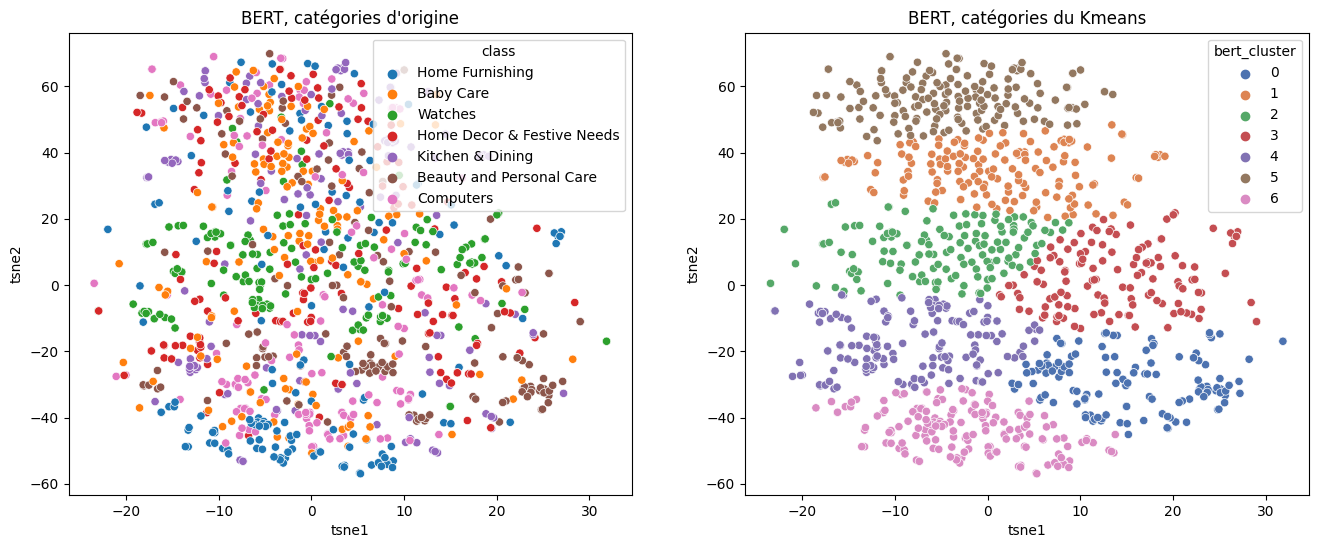

In [ ]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_bert_tsne, x="tsne1", y="tsne2", hue="class")
plt.title("BERT, catégories d'origine")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_bert_tsne, x="tsne1", y="tsne2", hue="bert_cluster", palette="deep")
plt.savefig('/content/drive/My Drive/Flipkart/Bert-plot.png')
plt.title("BERT, catégories du Kmeans")

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10

In [ ]:
features_USE = feature_USE_fct([' '.join(tokens) for tokens in sentences], batch_size)

In [ ]:
features_USE

array([[-0.05280602, -0.05271565,  0.02570681, ...,  0.04210246,
         0.0460609 , -0.03014737],
       [-0.05008936, -0.04623924, -0.00442642, ...,  0.03232167,
         0.02824773,  0.00697588],
       [-0.05391771, -0.04896051, -0.02080382, ...,  0.05178699,
        -0.03254647, -0.04767124],
       ...,
       [-0.02905765, -0.05085989, -0.01459222, ..., -0.00914606,
         0.05892385, -0.05072088],
       [-0.02387228, -0.05408251,  0.02824252, ...,  0.01632267,
        -0.01273695,  0.00678911],
       [-0.04572928, -0.05039886,  0.01687831, ...,  0.02521218,
        -0.01301585,  0.02013782]], dtype=float32)

In [ ]:
T_1 = time.time()

X_use_embedded = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(features_USE)

df_use_tsne = pd.DataFrame(X_use_embedded[:,0:2], columns=['tsne1', 'tsne2'])
df_use_tsne["class"] = data_cat_num['product_category']

use_clusters = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
use_clusters.fit(X_use_embedded)
df_use_tsne['use_cluster'] = use_clusters.labels_

ARI_use = np.round(metrics.adjusted_rand_score(data_cat_num['product_category'], use_clusters.labels_),4)
T_2 = np.round(time.time() - time1,0)

print("USE : ")
print("-----------------")
print("ARI : ", ARI_use, "time : ", T_2)
print("-----------------")

USE : 
-----------------
ARI :  0.4168 time :  191.0
-----------------


Text(0.5, 1.0, 'USE, catégories du Kmeans')

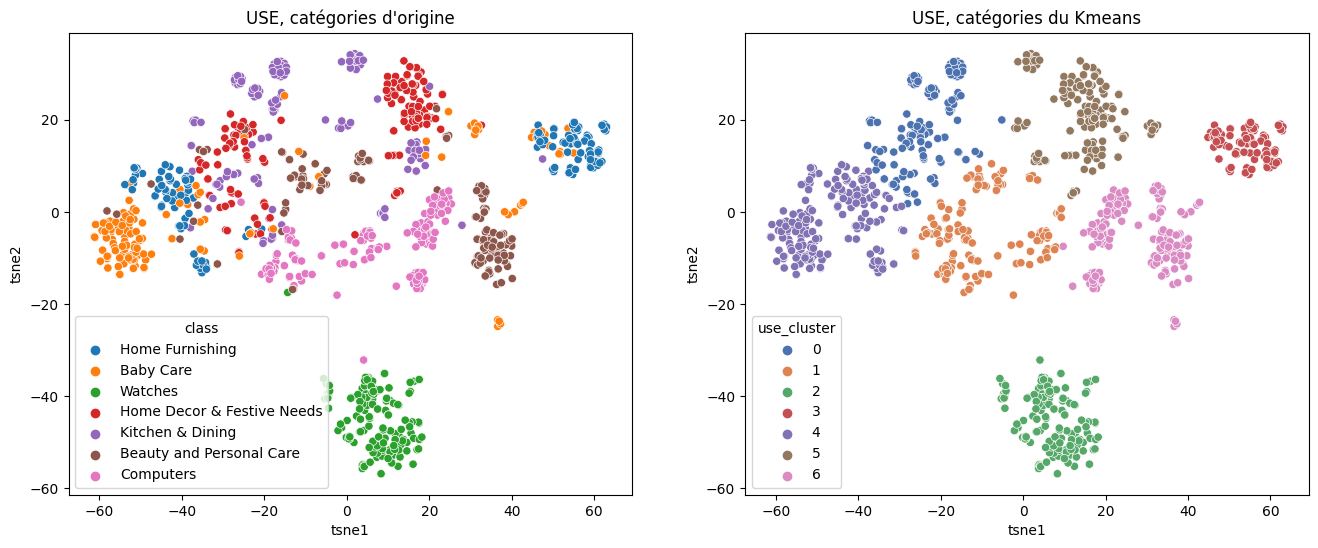

In [ ]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_use_tsne, x="tsne1", y="tsne2", hue="class")
plt.title("USE, catégories d'origine")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_use_tsne, x="tsne1", y="tsne2", hue="use_cluster", palette="deep")
plt.savefig('/content/drive/My Drive/Flipkart/Use-plot.png')
plt.title("USE, catégories du Kmeans")

# **Conclusion**

In [1]:
import pandas as pd

def create_results_dataframe(models, ari_scores, execution_times):
    results = pd.DataFrame({'Modèle': models, 'ARI': ari_scores, 'Temps d\'exécution': execution_times})
    return results


In [2]:
models = ['TD-idf', 'Word2Vec', 'BERT', 'USE']
ari_scores = [0.2058, 0.2933, 0.0854,  0.4168]
execution_times = [125.0, 28.0, 27.0,  191.0]

results_dataframe = create_results_dataframe(models, ari_scores, execution_times)
print(results_dataframe)


     Modèle     ARI  Temps d'exécution
0    TD-idf  0.2058              125.0
1  Word2Vec  0.2933               28.0
2      BERT  0.0854               27.0
3       USE  0.4168              191.0


Malgré le temps d'exécution relativement lent du modèle Use par rapport aux autres modèles, une analyse des valeurs de l'ARI, qui mesure la similarité entre les catégories d'origine et les clusters obtenus pour chaque modèle, suggère que le modèle Use peut offrir de meilleurs résultats en termes de correspondance entre les clusters.